# KIC 8462852 cc2 Astrometry

This notebook takes in the summary files that are aggregates of the MCMC chains used to fit the PSF of the star and companion in each image.  The format of these text files is: <br>
Image filename, Sep mean (mas), sep error (mas), pa mean (deg), pa err (deg), SNR primary, SNR secondary, DeltaMag, FWHM mean, FWHM err, Mean Gelman-Rubin stat for chains, GR stat std dev

Each step in the MCMC chain was corrected for detector distortion and atmopheric correction and burn in before computing the means in this file.

This notebook takes the image statistics in an epoch and computes epoch means, and produces plots in Fig 3, 6, and 7

** Note: I tried to clean this notebook up a bit but it's still very messy! It's not a final cleaned and polished version, it still has the remnants of my note taking and trying to figure things out.**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.io import ascii
from astropy.io.fits import getheader
from astropy.time import Time
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [13]:
## For Yelda epochs (< April 2015):
#pixscale = 9.952 #mas/pix
#pixscale_error = 0.002 #mas/pix
#orientation = 0.252 #deg
#orientation_error = 0.009 #deg

## For Service epochs (> April 2015):
#pixscale = 9.971 #mas/pix
#pixscale_error = 0.004 #mas/pix
#orientation = 0.262 #deg
#orientation_error = 0.020 #deg

In [14]:
############################################ 2016 #########################################################
pixscale = 9.971 #mas/pix

results = "2016_epoch_pasep_cc2"
pos = np.loadtxt(open(results,"rb")\
                 ,delimiter=",",usecols=(1,2,3,4,5,6,7,8,9))
filename = np.loadtxt(open(results,"rb"),\
                       dtype=str,delimiter=",",usecols=(0,))

# Parse all the data into arrays:
r = pos[:,0]  #Distance in arcseconds
r_std = pos[:,1] #std dev of sep
t_deg = pos[:,2]  #Angle in degrees
t_deg[7:9] = t_deg[7:9]+180.
t_std_deg = pos[:,3] # Angle std dev

# obs date in decimal year:
date = 2016.71857923

# Convert angle to mas - rho*DeltaTheta, where Theta is angle from due east:
t = r*np.tan(np.radians(270.-t_deg))
# Convert angle error to mas:
t_std = r*np.tan(np.radians(t_std_deg))

##### Mean values for separation and position angle:
r_weights = 1./(r_std**2)
r_mean = np.sum(r_weights*r)/np.sum(r_weights)
t_weights = 1./(t_std**2)
t_mean = np.sum(t_weights*t)/np.sum(t_weights)
t_weights_deg = 1./(t_std_deg**2)
t_mean_deg = np.sum(t_weights_deg*t_deg)/np.sum(t_weights_deg)

##### Image uncertainties:
rerr2016_1_thick = np.sqrt((1./np.sum(r_weights[0:2])))
terr2016_1_thick = np.sqrt((1./np.sum(t_weights[0:2])))
rerr2016_2_thick = np.sqrt((1./np.sum(r_weights[2:])))
terr2016_2_thick = np.sqrt((1./np.sum(t_weights[2:])))


##### Systematic Uncertainties:
### Dither 1: ###
uncerts1_2016 = np.sqrt((np.sqrt((1./np.sum(r_weights[0:2]))))**2 + (np.sqrt(2)**2))
uncertpa1_2016 = np.sqrt((np.sqrt((1./np.sum(t_weights[0:2]))))**2 + (np.sqrt(2)**2))

### Dither 2: ###
uncerts2_2016 = np.sqrt((np.sqrt((1./np.sum(r_weights[2:]))))**2 + (np.sqrt(2)**2))
uncertpa2_2016 = np.sqrt((np.sqrt((1./np.sum(t_weights[2:]))))**2 + (np.sqrt(2)**2))

#uncerts = 1/np.sqrt((1./np.sum([uncerts1**2,uncerts2**2])))
#uncertpa = 1/np.sqrt((1./np.sum([uncertpa1**2,uncertpa2**2])))
uncerts = np.mean([uncerts1_2016,uncerts2_2016])/np.sqrt(2)
uncertpa = np.mean([uncertpa1_2016,uncertpa2_2016])/np.sqrt(2)

rpix = r/pixscale #radius in pixels
pixerr = rpix*0.002 #pix * mas/pix = mas
uncerts = np.mean(np.sqrt(uncerts**2+pixerr**2))
orerr = 0.009 #deg
orerr = np.radians(orerr)
orerr = r*np.tan(orerr)
uncertpa = np.mean(np.sqrt(uncertpa**2+orerr**2))
terr2016_1_deg = np.degrees(np.arctan(uncertpa1_2016/np.mean(r[:2])))
terr2016_2_deg = np.degrees(np.arctan(uncertpa2_2016/np.mean(r[2:])))


################################################ Final output: ################################################
r2,t2,t2deg = r,t,t_deg
r2mean,t2mean,t2meandeg = r_mean,t_mean,t_mean_deg
#t2err_deg = terr_deg
#r2err_thick,t2err_thick = rerr_thick,terr_thick
r2err_thin,t2err_thin = uncerts,uncertpa
r2_std,t2_std_deg = r_std,t_std_deg
r2err_ind = np.median(r_std)
t2err_ind = np.median(t_std)
d2 = date
deltamag2 = pos[:,6]

r2016_1, t2016_1, tdeg2016_1 = r2[:2],t2[:2],t2deg[:2]
r2016_1_mean,t2016_1_mean,t2016_1_meandeg = np.mean(r2[:2]),np.mean(t2[:2]),np.mean(t2deg[:2])
r2016_1_err_thin,t2016_1_err_thin = uncerts1_2016,uncertpa1_2016
r2016_1_err_thick,t2016_1_err_thick = rerr2016_1_thick,terr2016_1_thick
r2016_1_err_std,t2016_1_err_std = np.std(r2[:2]),np.std(t2[:2])

r2016_2, t2016_2, tdeg2016_2 = r2[2:],t2[2:],t2deg[2:]
r2016_2_mean,t2016_2_mean,t2016_2_meandeg = np.mean(r2[2:]),np.mean(t2[2:]),np.mean(t2deg[2:])
r2016_2_err_thin,t2016_2_err_thin = uncerts2_2016,uncertpa2_2016
r2016_2_err_thick,t2016_2_err_thick = rerr2016_2_thick,terr2016_2_thick
r2016_2_err_std,t2016_2_err_std = np.std(r2[2:]),np.std(t2[2:])

In [15]:
############################################ 2019 #########################################################
pixscale = 9.971 #mas/pix

results = "2019_epoch_pasep_cc2"
pos = np.loadtxt(open(results,"rb")\
                 ,delimiter=",",usecols=(1,2,3,4,5,6,7,8,9))
filename = np.loadtxt(open(results,"rb"),\
                       dtype=str,delimiter=",",usecols=(0,))

# Parse all the data into arrays:
r = pos[:,0]  #Distance in arcseconds
r_std = pos[:,1] #std dev of sep
t_deg = pos[:,2]+180.  #Angle in degrees
t_std_deg = pos[:,3] # Angle std dev

# obs date in decimal year:
date = 2019.44383562

# Convert angle to mas - rho*DeltaTheta, where Theta is angle from due east:
t = np.radians(270.-t_deg)
t = r*np.tan(t)
t_std = np.radians(t_std_deg)
t_std = r*np.tan(t_std)

##### Mean values for separation and position angle:
r_weights = 1./(r_std**2)
r_mean = np.sum(r_weights*r)/np.sum(r_weights)
t_weights = 1./(t_std**2)
t_mean = np.sum(t_weights*t)/np.sum(t_weights)
t_weights_deg = 1./(t_std_deg**2)
t_mean_deg = np.sum(t_weights_deg*t_deg)/np.sum(t_weights_deg)

##### Image uncertainties:
rerr2019_1_thick = np.sqrt((1./np.sum(r_weights[0:2])))
terr2019_1_thick = np.sqrt((1./np.sum(t_weights[0:2])))
rerr2019_2_thick = np.sqrt((1./np.sum(r_weights[2:])))
terr2019_2_thick = np.sqrt((1./np.sum(t_weights[2:])))

##### Systematic Uncertainties:
### Dither 1: ###
uncerts1_2019 = np.sqrt((np.sqrt((1./np.sum(r_weights[0:2]))))**2 + (np.sqrt(2)**2))
uncertpa1_2019 = np.sqrt((np.sqrt((1./np.sum(t_weights[0:2]))))**2 + (np.sqrt(2)**2))

### Dither 2: ###
uncerts2_2019 = np.sqrt((np.sqrt((1./np.sum(r_weights[2:]))))**2 + (np.sqrt(2)**2))
uncertpa2_2019 = np.sqrt((np.sqrt((1./np.sum(t_weights[2:]))))**2 + (np.sqrt(2)**2))


#uncerts = 1/np.sqrt((1./np.sum([uncerts1**2,uncerts2**2])))
#uncertpa = 1/np.sqrt((1./np.sum([uncertpa1**2,uncertpa2**2])))
uncerts = np.mean([uncerts1_2019,uncerts2_2019])/np.sqrt(2)
uncertpa = np.mean([uncertpa1_2019,uncertpa2_2019])/np.sqrt(2)

rpix = r/pixscale #radius in pixels
pixerr = rpix*0.002 #pix * mas/pix = mas
uncerts = np.mean(np.sqrt(uncerts**2+pixerr**2))
orerr = 0.009 #deg
orerr = np.radians(orerr)
orerr = r*np.tan(orerr)
uncertpa = np.mean(np.sqrt(uncertpa**2+orerr**2))
terr_deg = np.degrees(np.arctan(uncertpa/np.mean(r_mean)))
terr2019_1_deg = np.degrees(np.arctan(uncertpa1_2019/np.mean(r[:2])))
terr2019_2_deg = np.degrees(np.arctan(uncertpa2_2019/np.mean(r[2:])))

################################################ Final output: ################################################
r3,t3,t3deg = r,t,t_deg
r3mean,t3mean,t3meandeg = r_mean,t_mean,t_mean_deg
#t3err_deg = terr_deg
#r3err_thick,t3err_thick = rerr_thick,terr_thick
r3err_thin,t3err_thin = uncerts,uncertpa
r3_std,t3_std_deg = r_std,t_std_deg
r3err_ind = np.median(r_std)
t3err_ind = np.median(t_std)
d3 = date
deltamag3 = pos[:,6]

r2019_1, t2019_1, tdeg2019_1 = r3[:2],t3[:2],t3deg[:2]
r2019_1_mean,t2019_1_mean,t2019_1_meandeg = np.mean(r3[:2]),np.mean(t3[:2]),np.mean(t3deg[:2])
r2019_1_err_thin,t2019_1_err_thin = uncerts1_2019,uncertpa1_2019
r2019_1_err_thick,t2019_1_err_thick = rerr2019_1_thick,terr2019_1_thick
r2019_1_err_std,t2019_1_err_std = np.std(r3[:2]),np.std(t3[:2])

r2019_2, t2019_2, tdeg2019_2 = r3[2:],t3[2:],t3deg[2:]
r2019_2_mean,t2019_2_mean,t2019_2_meandeg = np.mean(r3[2:]),np.mean(t3[2:]),np.mean(t3deg[2:])
r2019_2_err_thin,t2019_2_err_thin = uncerts2_2019,uncertpa2_2019
r2019_2_err_thick,t2019_2_err_thick = rerr2019_2_thick,terr2019_2_thick
r2019_2_err_std,t2019_2_err_std = np.std(r3[2:]),np.std(t3[2:])

In [16]:
# Separate by filter band:
print('These match Table 1 in the paper:')

sep_2016_1 = np.array([r2016_1_mean, r2016_1_err_thick])
sep_2016_2 = np.array([r2016_2_mean, r2016_2_err_thick])
print('Sep 2016 Dither 1:',sep_2016_1)
print('Sep 2016 Dither 2:',sep_2016_2)
pa_2016_1 = np.array([t2016_1_meandeg, terr2016_1_deg])
pa_2016_2 = np.array([t2016_2_meandeg, terr2016_2_deg])
print('PA 2016 Dither 1:',pa_2016_1)
print('PA 2016 Dither 2:',pa_2016_2)
print()

sep_2019_1 = np.array([r2019_1_mean, r2019_1_err_thick])
sep_2019_2 = np.array([r2019_2_mean, r2019_2_err_thick])
print('Sep 2019 Dither 1:',sep_2019_1)
print('Sep 2019 Dither 2:',sep_2019_2)
pa_2019_1 = np.array([t2019_1_meandeg, terr2019_1_deg])
pa_2019_2 = np.array([t2019_2_meandeg, terr2019_2_deg])
print('PA 2019 Dither 1:',pa_2019_1)
print('PA 2019 Dither 2:',pa_2019_2)
#,terr2016_2_deg,terr2019_1_deg,terr2019_2_deg

These match Table 1 in the paper:
Sep 2016 Dither 1: [2784.80189693    6.62343538]
Sep 2016 Dither 2: [2788.22317564    5.87104698]
PA 2016 Dither 1: [2.32513805e+02 1.30004727e-01]
PA 2016 Dither 2: [2.32458695e+02 1.17421736e-01]

Sep 2019 Dither 1: [2760.75449128    3.060414  ]
Sep 2019 Dither 2: [2.76281666e+03 1.95479256e+00]
PA 2019 Dither 1: [2.32498036e+02 6.98838694e-02]
PA 2019 Dither 2: [2.32523950e+02 5.07458283e-02]


In [17]:
# Make some arrays for easier plotting:
# Obs dates:
date = np.array([d2,d2,d3,d3],dtype='float')

# Separation array of images in mas
r = np.array([r2,r3]) 
# Separation mean values
rmeans = np.array([r2016_1_mean,r2016_2_mean,r2019_1_mean,r2019_2_mean])
# Position array of images in mas
t = np.array([t2,t3]) 
# Position angle mean values
# in mas:
tmeans = np.array([t2016_1_mean,t2016_2_mean,t2019_1_mean,t2019_2_mean])
# in degrees:
tmeansdeg = np.array([t2016_1_meandeg,t2016_2_meandeg,t2019_1_meandeg,t2019_2_meandeg])

###### Uncertainties:
### Separation:
# Scatter:
rerrmeans_thick = np.array([r2016_1_err_thick,r2016_2_err_thick,r2019_1_err_thick,\
                            r2019_2_err_thick])
terrmeans_thick = np.array([t2016_1_err_thick,t2016_2_err_thick,t2019_1_err_thick,\
                            t2019_2_err_thick])
sigmas_std = np.array([r2016_1_err_std,r2016_2_err_std,r2019_1_err_std,r2019_2_err_std,\
                  t2016_1_err_std,t2019_1_err_std,t2016_2_err_std,t2019_2_err_std])


# Systematic:
rerrmeans_thin = np.array([r2016_1_err_thin,r2016_2_err_thin,r2019_1_err_thin,\
                            r2019_2_err_thin])
terrmeans_thin = np.array([t2016_1_err_thin,t2016_2_err_thin,t2019_1_err_thin,\
                            t2019_2_err_thin])

terrmeansdeg = np.array([terr2016_1_deg,terr2016_2_deg,terr2019_1_deg,terr2019_2_deg])

In [18]:
# Mean sep ant PA:
ref_rmean = np.average([r2016_1_mean,r2016_2_mean,r2019_1_mean,\
                                      r2019_2_mean], 
                                weights = np.array([r2016_1_err_thin,rerr2016_2_thick,\
                                                  r2019_1_err_thin,rerr2019_2_thick])**(-1))

ref_tmean = np.average([t2016_1_mean,t2016_2_mean,t2019_1_mean,\
                                      t2019_2_mean], 
                                        weights = 1/np.array([t2016_1_err_thin,terr2016_2_thick,\
                                                  t2019_1_err_thin,terr2019_2_thick]))



In [19]:
date2 = np.array([2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])
date_str2 = np.array(['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'])

In [20]:
# Normalize angles to first epoch to show change over time:
# Setting 2014 epoch to zero
tmeans_norm = tmeans-tmeans[0]
t_norm = np.array([t2-tmeans[0],t3-tmeans[0]])


rmeans_norm = rmeans-rmeans[0]

### Fit a line to the astrometry to get linear velocity:

In [21]:
from scipy.optimize import curve_fit
#Line function to fit:
def f(x, a, b):
    return a * x + b

# Make array of x values:
x_val = np.linspace(2008,2022,10)
popt4, pcov4 = curve_fit(f, date, rmeans, sigma=rerrmeans_thin, absolute_sigma=True)
line4 = popt4[0]*x_val + popt4[1]
popt5, pcov5 = curve_fit(f, date, -tmeans_norm, sigma=terrmeans_thin, absolute_sigma=True)
line5 = popt5[0]*x_val + popt5[1]
popt6, pcov6 = curve_fit(f, date, -tmeans, sigma=terrmeans_thin, absolute_sigma=True)
line6 = popt6[0]*x_val + popt6[1]

print('separation velocity =',popt4[0],'\pm ',np.sqrt(pcov4[0][0]))
print('pa velocity ',popt5[0],'\pm ',np.sqrt(pcov5[0][0]))
print('   This matches quoted velocity:')
print('total velocity ',(np.sqrt(popt4[0]**2 + popt5[0]**2)),'\pm',np.sqrt(pcov4[0][0]+pcov5[0][0]))

from tools import to_si
dist = [451.0,4.9]
total_vel = ( np.sqrt(popt4[0]**2 + popt5[0]**2), np.sqrt(pcov4[0][0]+pcov5[0][0]) )
total_vel_array = np.random.normal(total_vel[0],total_vel[1],10000)
dist_array = np.random.normal(dist[0],dist[1],10000)
total_vel_kms_array = to_si(0,total_vel_array,dist_array)
print('Velocity in km/s',np.mean(total_vel_kms_array[1]),np.std(total_vel_kms_array[1]))

separation velocity = -9.0228662447734 \pm  1.8038318836517315
pa velocity  7.811680369606801 \pm  1.7164138004342528
   This matches quoted velocity:
total velocity  11.93459113116036 \pm 2.4899569873392813
Velocity in km/s 25.553956068088947 5.3751583883559215


In [22]:
r_model_fit = popt4[0]*date + popt4[1]
t_model_fit = popt5[0]*date + popt5[1]


In [23]:
# Proper motion: from Gaia
from astroquery.gaia import Gaia
# Boyajian's star's source id:
source_id = 2081900940499099136
# Get Boyajian's star Gaia data:
catalog = 'gaiadr2.gaia_source'
job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_id))
j = job.get_results()

pmRA = j['pmra'][0] #mas/yr
pmDec = j['pmdec'][0]
print(pmRA,pmDec)
bkgd_star_vel_vector = np.sqrt(pmRA**2+pmDec**2)

-10.422167102482083 -10.288032982297423


In [24]:
#################### Calculate tangential velocity #############################

# Tangential velocity:
tvel = np.sqrt(popt4[0]**2+popt6[0]**2)

# Error on tang vel:
# The covariance matrix given by fit is the variance in both parameters - the slope and the 
# y-intercept.  This extracts the diagonal of the matrix and gets the sigma for both parameters 
# in the fit:
perr4 = np.sqrt(np.diag(pcov4))
perr5 = np.sqrt(np.diag(pcov6))
# Add them in quadrature:
tvel_err = np.sqrt(perr4[0]**2+perr5[0]**2)
print('Tangential velocity',tvel,'+/-',tvel_err)


Tangential velocity 11.934591131419355 +/- 2.489963787751185


In [25]:
# Normalize sep/pa of individual images to 2014 mean:
t_norms = np.array([t2-tmeans[0],t3-tmeans[0]])
r_norms = [r2-rmeans[0],r3-rmeans[0]]
labels = ['2016-1','2016-2','2019-1','2019-2']

<IPython.core.display.Javascript object>


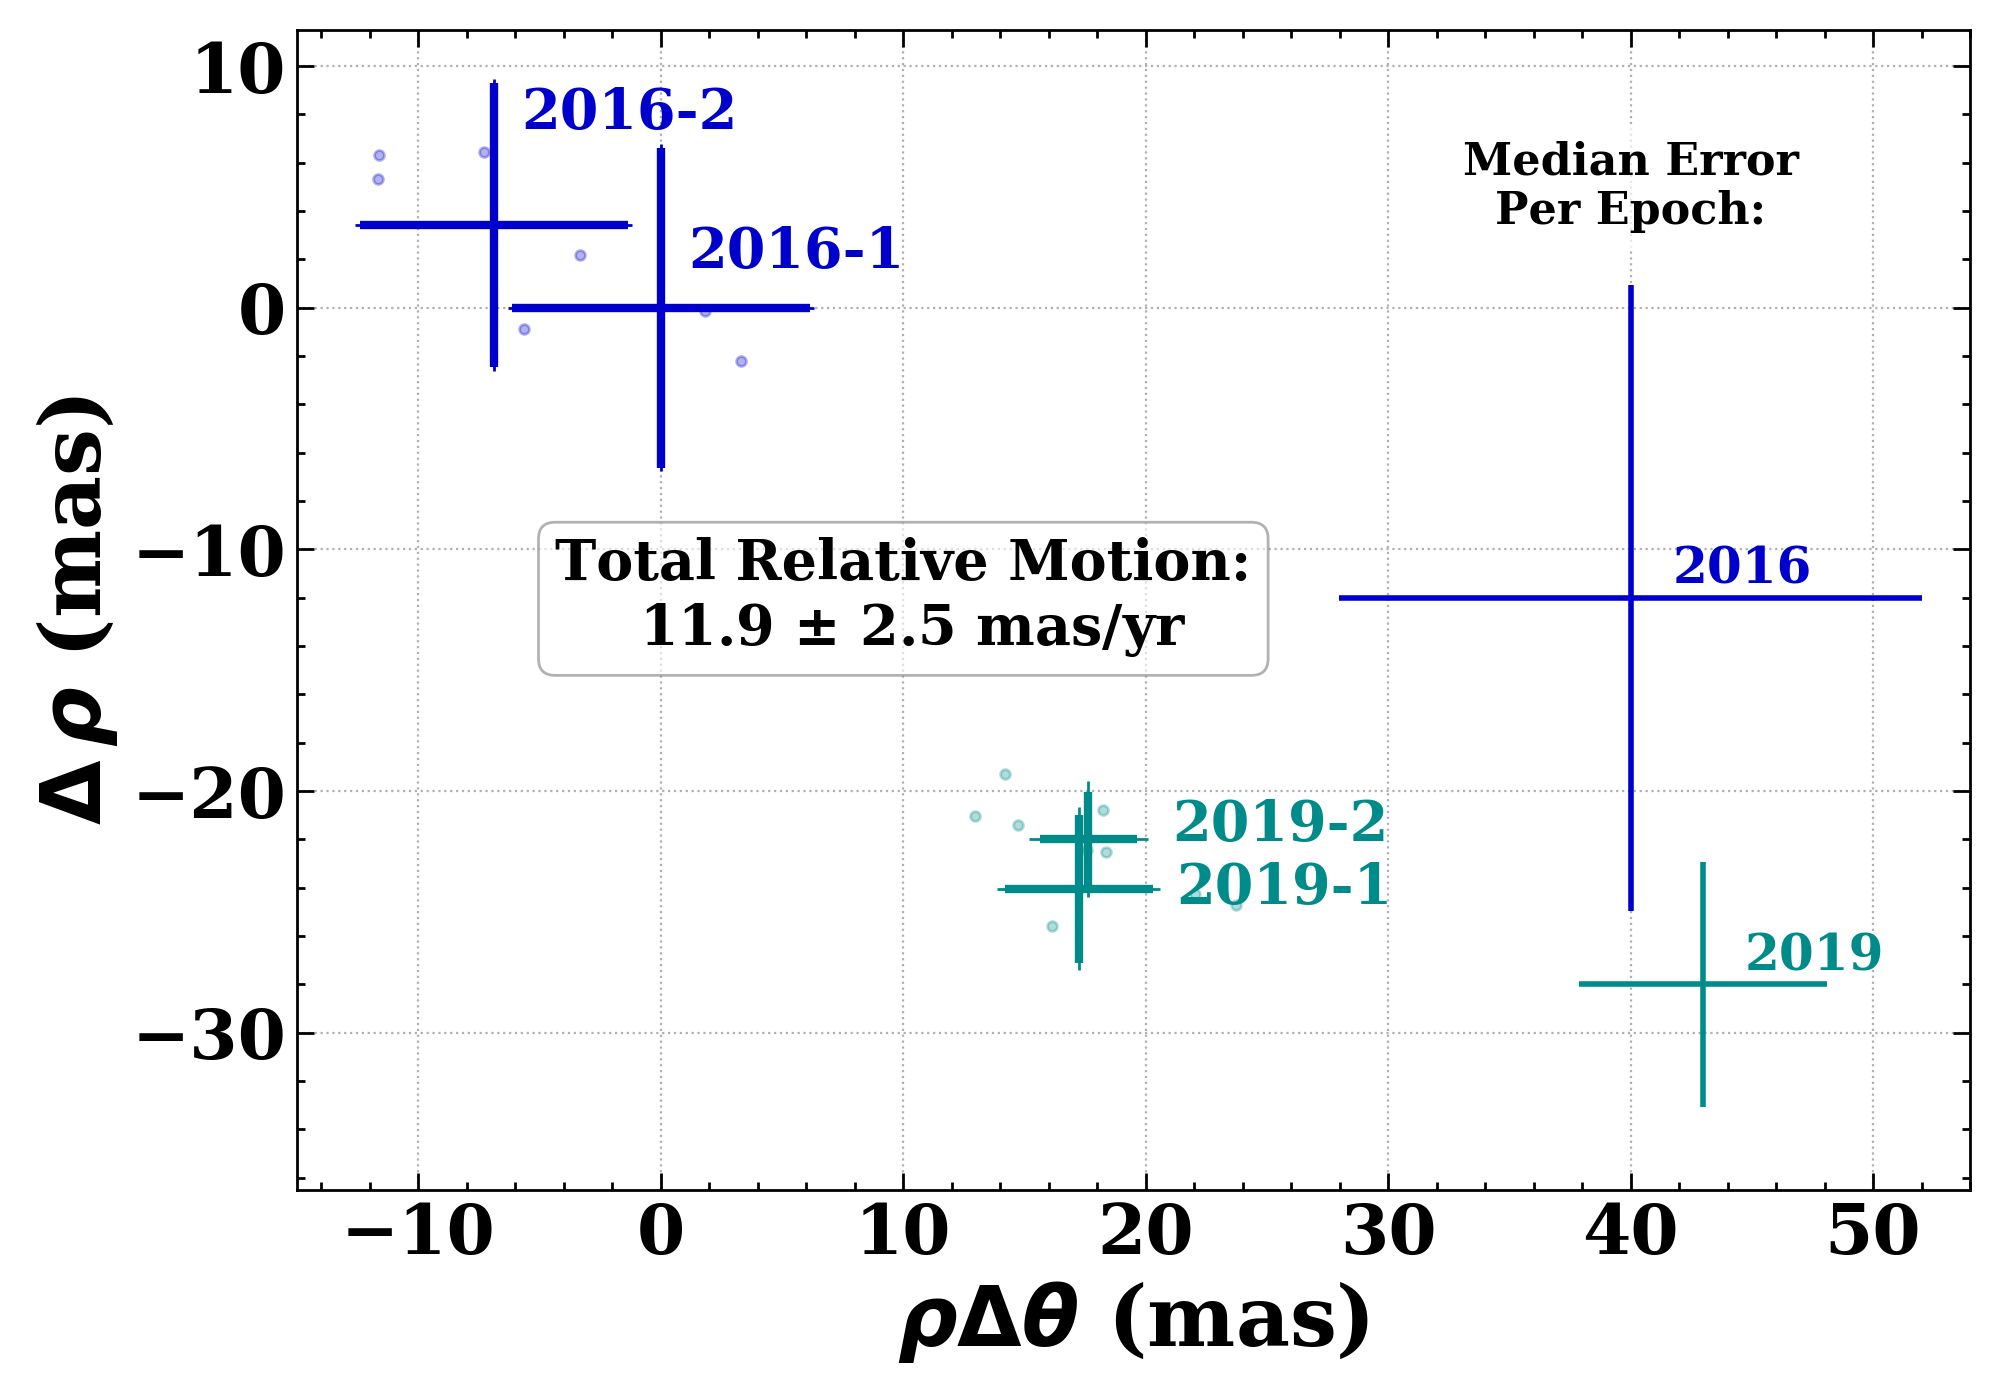

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.units as u
import astropy.constants as c
plt.style.use('magrathea_bold')
%matplotlib notebook

x_val = np.linspace(2008,2020,10)
popt4, pcov4 = curve_fit(f, date, rmeans_norm, sigma=rerrmeans_thin, absolute_sigma=True)
line4 = popt4[0]*x_val + popt4[1]
popt5, pcov5 = curve_fit(f, date, -tmeans_norm, sigma=terrmeans_thin, absolute_sigma=True)
line5 = popt5[0]*x_val + popt5[1]
popt6, pcov6 = curve_fit(f, date, tmeans, sigma=terrmeans_thin, absolute_sigma=True)
line6 = popt6[0]*x_val + popt6[1]


################################# Rainbow plot #####################################
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7.0)
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['xtick.labelsize'] = 25

start = 0.0
stop = 1.0
number_of_lines= 8
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [ cm.Dark2(x) for x in cm_subsection ]
colors = ['mediumblue','mediumblue','darkcyan','darkcyan','green','orange','red']

offset_points_x = [10,10,35,30]
offset_points_y = [20,40,0,5]
for i in range(len(rmeans_norm)):
    plt.errorbar(-tmeans_norm[i], rmeans_norm[i], yerr=rerrmeans_thin[i], xerr=terrmeans_thin[i], ls='none',
             color=colors[i],elinewidth=1,capsize=0,label=labels[i])
    plt.errorbar(-tmeans_norm[i], rmeans_norm[i], yerr=rerrmeans_thick[i], xerr=terrmeans_thick[i], ls='none',
             color=colors[i],elinewidth=3,capsize=0,label=labels[i])
    plt.annotate(labels[i], xy=(-tmeans_norm[i], rmeans_norm[i]), xytext=(offset_points_x[i], offset_points_y[i]),
             textcoords='offset points', ha='left', va='center', color=colors[i], fontsize=20)
for i in range(2):
    plt.scatter(-t_norms[i],r_norms[i],color=colors[i*2],marker='.',alpha=0.3, s=50)

plt.xlim(-15,54)
plt.ylim(-35,10)
#plt.xlabel(r'$\Delta$ PA (mas)')
plt.xlabel(r'$\rho \Delta \theta$ (mas)', fontsize = 30)
plt.ylabel(r"$\Delta\,\rho$ (mas)", fontsize = 30)

x, y=40, -30
yplus = [0,18,2]
dx=0.25
plt.errorbar(x, y+yplus[1], yerr=t2err_ind, xerr=r2err_ind, ls='none',
             color=colors[0],elinewidth=2,capsize=0)
plt.errorbar(x+3, y+yplus[2], yerr=t3err_ind, xerr=r3err_ind, ls='none',
             color=colors[2],elinewidth=2,capsize=0)

plt.annotate('2016', xy=(x,y+yplus[1]), xytext=(15, 10),
             textcoords='offset points', ha='left', va='center', color=colors[0], fontsize = 18)
plt.annotate('2019', xy=(x+3,y+yplus[2]), xytext=(15, 10),
             textcoords='offset points', ha='left', va='center', color=colors[2], fontsize = 18)

ax = plt.gca()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.6)
bbox_props2 = dict(boxstyle="round", fc="w", ec="w", alpha=0.7)
ax.text(10, -12, "Total Relative Motion:\n {0} $\pm$ {1} mas/yr".format(np.round(tvel,decimals=1),\
            np.round(tvel_err,decimals=1)), ha="center", va="center", size=20, #fontname='Courier',
        bbox=bbox_props)
ax.text(x, y+yplus[-1]+33, "Median Error\nPer Epoch:", ha="center", va="center", size=16, #fontname='Courier',
        bbox=bbox_props2)


#plt.xticks([0,10, 20, 30], ['0','10', '20','30'])
majorLocator   = MultipleLocator(2.5)
majorFormatter = FormatStrFormatter('%d')
minorLocator   = MultipleLocator(2.5)
plt.grid(linestyle='dotted')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.tight_layout()
plt.show()

## Common Proper Motion:

In [27]:
obsdate = date
epochs = ['2016','2019']
obs_RAs, obs_Decs = np.zeros(len(epochs)),np.zeros(len(epochs))
obs_RAs_err, obs_Decs_err = np.zeros(len(epochs)),np.zeros(len(epochs))

for i in range(len(epochs)):
    pos = np.loadtxt(open(epochs[i]+'_epoch_radec_cc2',"rb")\
                 ,delimiter=",",usecols=(1,2,3,4))
    obs_RAs[i],obs_RAs_err[i] = np.mean(pos[:,0]),np.mean(pos[:,1])
    obs_Decs[i],obs_Decs_err[i] = np.mean(pos[:,2]),np.mean(pos[:,3])


# Specify a reference time:
time = Time(obsdate[0],format='decimalyear',scale='utc')

obs_RAs[0] = -obs_RAs[0]
obs_Decs[1] = -obs_Decs[1]
print(obs_RAs, obs_RAs_err)
print(obs_Decs, obs_Decs_err)

[-2191.19237284 -2192.04926883] [53.90302626  4.99867683]
[-1757.21285543 -1680.94605353] [51.15004381  5.18303879]


Something went wrong with these^, let's just calculate them:

In [28]:
# Sep/PA for epochs with both dithers combined:
sep,seperr = np.array([2788.48891377, 2762.20171484]), np.array([4.39348958, 1.64741163])
pa,paerr = np.array([232.48529694, 232.51412836]), np.array([0.08787548, 0.04357966])

# Convert to RA/Dec with errors using Monte Carlo approach:
obs_RAs,obs_RAs_err = np.zeros(len(sep)),np.zeros(len(sep))
obs_Decs,obs_Decs_err = np.zeros(len(sep)),np.zeros(len(sep))

obs_RAs = [np.mean(
                 np.random.normal( sep[i],seperr[i],10000 ) * 
                 np.sin( np.radians( np.random.normal( pa[i],paerr[i],10000 ) ) ) 
                 ) 
          for i in range(len(sep))]
obs_RAs_err = [np.std(
                    np.random.normal( sep[i],seperr[i],10000 ) * 
                    np.sin( np.radians( np.random.normal( pa[i],paerr[i],10000 ) ) ) 
                    ) 
             for i in range(len(sep))] 
print(obs_RAs)
print(obs_RAs_err)

obs_Decs = [np.mean(
                  np.random.normal( sep[i],seperr[i],10000 ) * 
                  np.cos( np.radians( np.random.normal( pa[i],paerr[i],10000 ) ) ) 
                  ) 
           for i in range(len(sep))]
obs_Decs_err = [np.std(
                    np.random.normal( sep[i],seperr[i],10000 ) * 
                    np.cos( np.radians( np.random.normal( pa[i],paerr[i],10000 ) ) ) 
                    ) 
              for i in range(len(sep))] 
print(obs_Decs, obs_Decs_err)

[-2211.8209560069495, -2191.780098763497]
[4.347541655425485, 1.842103358296067]
[-1698.0771100818044, -1681.012343785896] [4.305404834215697, 1.9426428876270754]


In [29]:
deg_to_mas = 3600000.
mas_to_deg = 1./3600000.

In [30]:
from astroquery.gaia import Gaia
source_id = 2081900940499099136
job = Gaia.launch_job("SELECT * FROM gaiadr2.gaia_source WHERE source_id = "+str(source_id))
j = job.get_results()

RA, RAerr, Dec, Decerr = j['ra'][0],j['ra_error'][0]*mas_to_deg,j['dec'][0],j['dec_error'][0]*mas_to_deg
pmRA,pmRAerr,pmDec,pmDecerr = j['pmra'][0],j['pmra_error'][0],j['pmdec'][0],j['pmdec_error'][0]
parallax, parallax_error = j['parallax'][0],j['parallax_error'][0]

2016.7185792527237


<IPython.core.display.Javascript object>


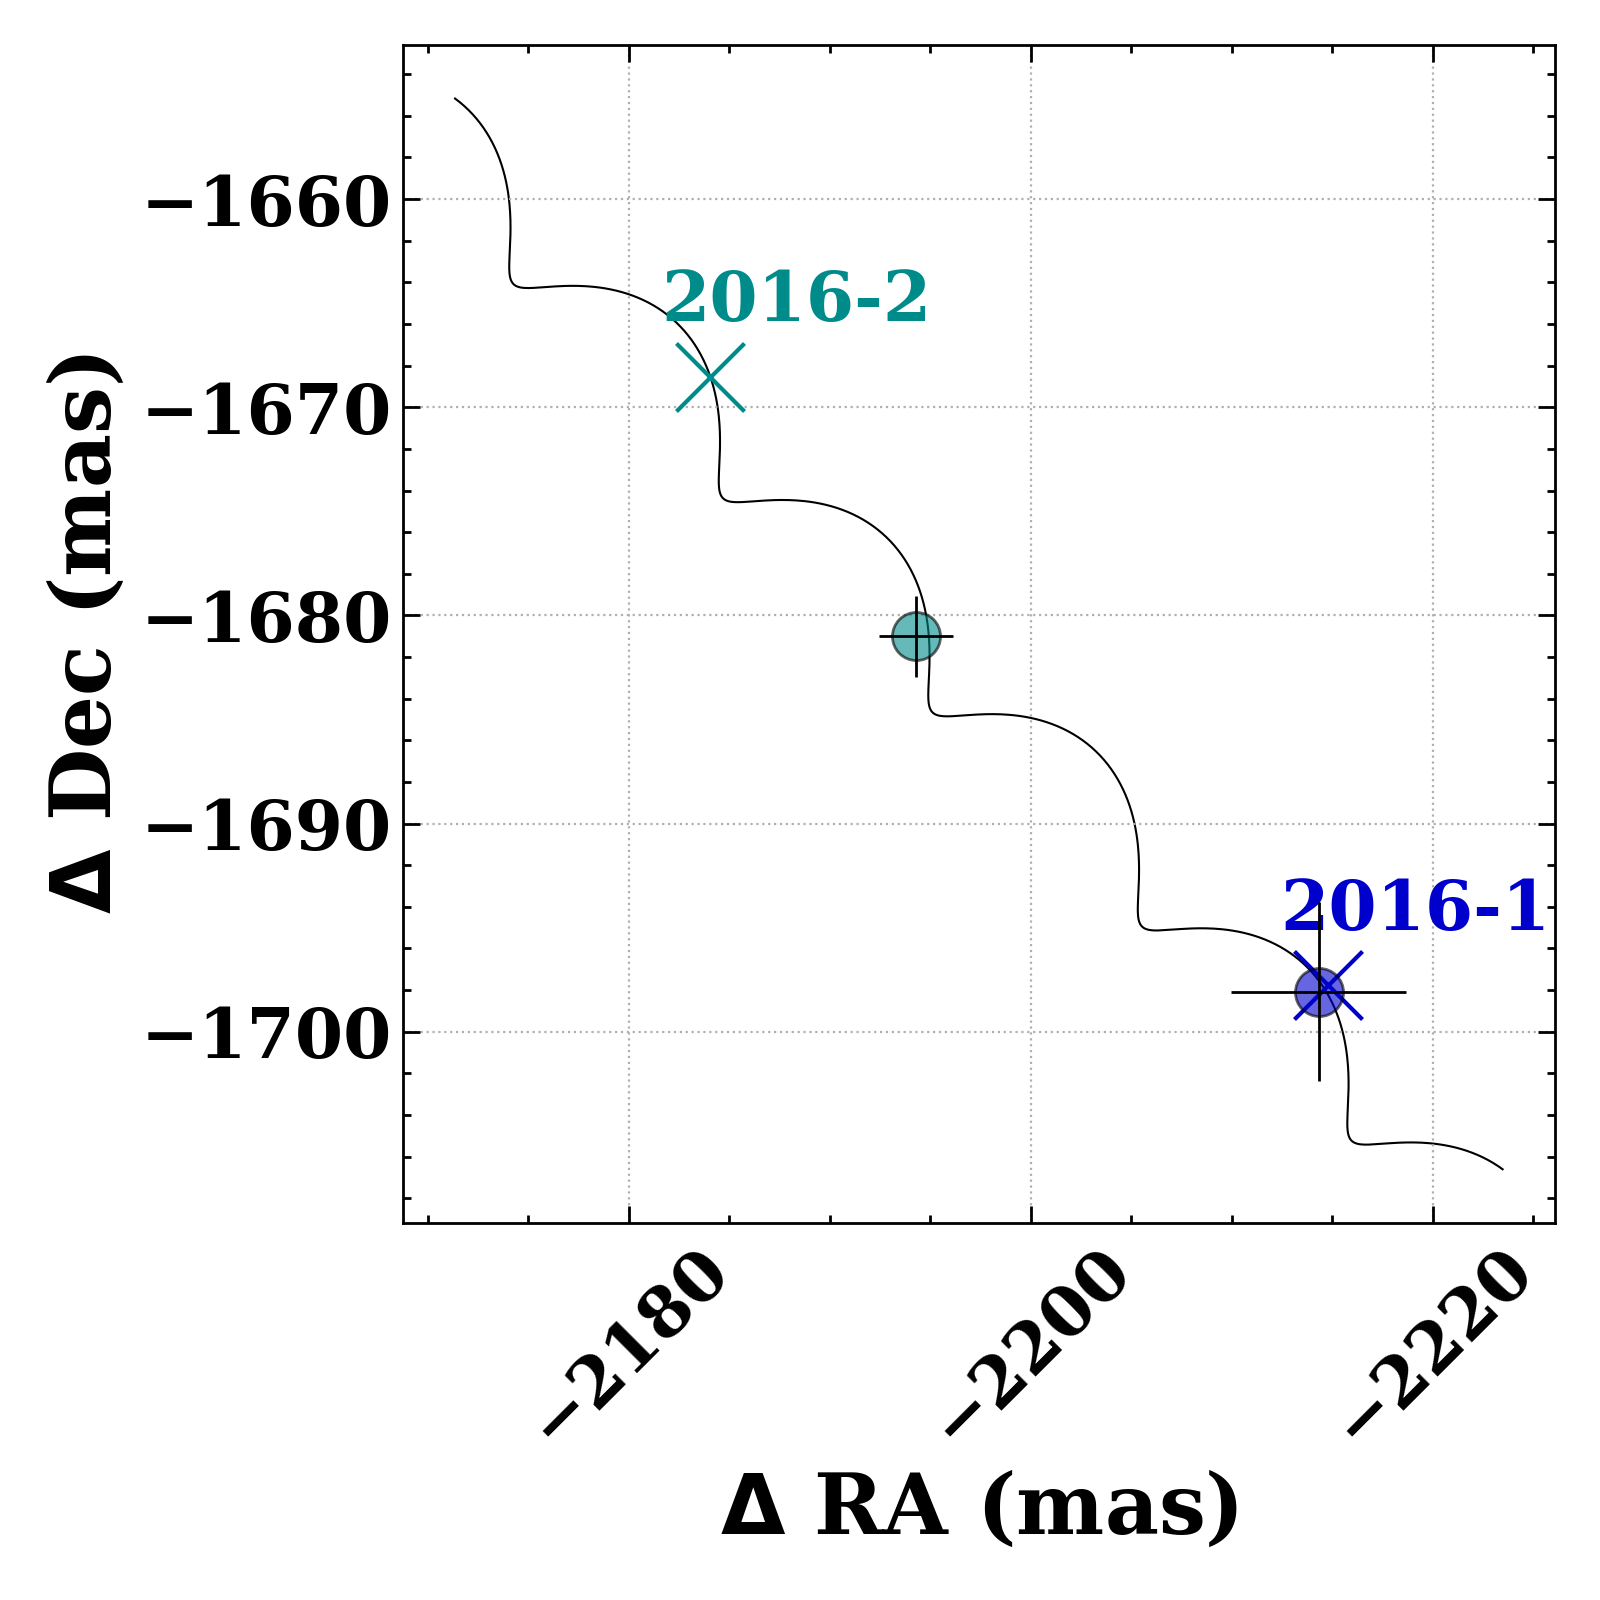

In [32]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, GeocentricTrueEcliptic
from astropy import units as u
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from myastrotools.astrometry import ecliptic_to_equatorial
# Ref epoch:
ref_index = 0
# Specify a reference time:
obsdate = np.array([d2,d3],dtype='float')
ref_date = Time(obsdate[ref_index],format='decimalyear',scale='utc')
print(ref_date)
time_interval=[1,4]
ref_RA_offset = obs_RAs[ref_index]
ref_Dec_offset = obs_Decs[ref_index]
marker_size = [600,300]
label_offset = [80,15]
labelsize = 25
plt_style = 'magrathea_bold',
colors = ['mediumblue','darkcyan']
n_times = 800
xlabel = r'$\Delta$ RA (mas)'
ylabel = r'$\Delta$ Dec (mas)'
marker = ['x','o']
fontsize = 20
tick_labelsize = 25
alpha=0.6
figsize = (8,8)
output_name = 'cpm.pdf'
form = 'pdf'
plt_xlim=None
plt_ylim=None

RA, RAerr, Dec, Decerr = j['ra'][0],j['ra_error'][0]*mas_to_deg,j['dec'][0],j['dec_error'][0]*mas_to_deg
pmRA,pmRAerr,pmDec,pmDecerr = j['pmra'][0],j['pmra_error'][0],j['pmdec'][0],j['pmdec_error'][0]
parallax, parallax_error = j['parallax'][0],j['parallax_error'][0]
pmRA = -pmRA
pmDec = - pmDec

%matplotlib notebook
plt.style.use('magrathea_bold')
deg_to_mas = 3600000.
mas_to_deg = 1./3600000.
############### Compute track: ###################
# Define a time span around reference date:
delta_time = np.linspace(-time_interval[0], time_interval[1], n_times)*u.yr
times = ref_date + delta_time

# Compute change in RA/Dec during time interval due to proper motion only:
dRA, dDec = (pmRA)*(delta_time.value), (pmDec)*(delta_time.value)

# Compute motion in the ecliptic coords due to parallactic motion:
# Make a sky coord object in RA/Dec:
obj = SkyCoord(ra = RA, dec = Dec, frame='icrs', unit='deg'#, obstime = 'J2015.5'
              ) 
# Convert to ecliptic lon/lat:
gteframe = GeocentricTrueEcliptic()
obj_ecl = obj.transform_to(gteframe)

# Angle array during a year:
theta = (delta_time.value%1)*2*np.pi
#Parallel to ecliptic:
x = parallax*np.sin(theta)  
#Perp to ecliptic
y = parallax*np.sin(obj_ecl.lat.rad)*np.cos(theta)

# Compute ecliptic motion to equatorial motion:
new_RA, new_Dec = ecliptic_to_equatorial(obj_ecl.lon.deg+x*mas_to_deg, \
                                       obj_ecl.lat.deg+y*mas_to_deg)
from astropy.coordinates import SkyCoord
maxecl_lon = np.max(obj_ecl.lon.deg+x*mas_to_deg)
maxecl_lat = np.max(obj_ecl.lat.deg+y*mas_to_deg)
obj2 = SkyCoord(lon = maxecl_lon,\
                    lat = maxecl_lat, \
                    frame='geocentrictrueecliptic', unit='deg')
obj2 = obj2.transform_to('icrs')


# Compute change in RA/Dec for each time point in mas:
delta_RA, delta_Dec = (new_RA-RA)*deg_to_mas,(new_Dec-Dec)*deg_to_mas

#Put it together:
dRA_total = delta_RA + dRA + ref_RA_offset
dDec_total = delta_Dec + dDec + ref_Dec_offset

############# Compute prediction: #############
### Where the object would have been observed were it a background object

# Compute how far into each year the observation occured:
pred_time_delta = (obsdate - np.floor(obsdate))
pred_theta = (pred_time_delta)*2*np.pi

# Compute ecliptic motion:
pred_x = parallax*np.sin(pred_theta)  #Parallel to ecliptic
pred_y = parallax*np.sin(obj_ecl.lat.rad)*np.cos(pred_theta)  #Perp to ecliptic

# Convert to RA/Dec:
pred_new_RA, pred_new_Dec = ecliptic_to_equatorial(obj_ecl.lon.deg+pred_x*mas_to_deg, \
                                       obj_ecl.lat.deg+pred_y*mas_to_deg)
pred_delta_RA, pred_delta_Dec = (pred_new_RA-RA)*deg_to_mas,(pred_new_Dec-Dec)*deg_to_mas

# Compute location due to proper motion:
pred_dRA, pred_dDec = (pmRA)*(obsdate-ref_date.value), (pmDec)*(obsdate-ref_date.value)

# Put it together:
pred_dRA_total = -pred_delta_RA + pred_dRA + ref_RA_offset
pred_dDec_total = -pred_delta_Dec + pred_dDec + ref_Dec_offset

#################### Draw plot: #################
plt.rcParams['ytick.labelsize'] = tick_labelsize
plt.rcParams['xtick.labelsize'] = tick_labelsize
custom_cycler = (cycler(color=colors))
fig = plt.figure(figsize = figsize)
#plt.plot(dRA_total,dDec_total, lw=3, color='lightgrey', alpha = 0.5, zorder = 0)
plt.plot(dRA_total,dDec_total, zorder = 1, color='black',lw=0.75)
plt.gca().set_prop_cycle(custom_cycler)

triangleoffsets_ra = [-4,1,-3]
triangleoffsets_dec = [-0.5,0,0]
for i in range(len(pred_dRA)):
    plt.scatter(pred_dRA_total[i]+triangleoffsets_ra[i], pred_dDec_total[i]+triangleoffsets_dec[i], 
                marker = marker[0], s=marker_size[0], zorder=2, 
                edgecolors='black')
    plt.annotate(
        labels[i],
        xy=(pred_dRA_total[i]+triangleoffsets_ra[i], pred_dDec_total[i]+triangleoffsets_dec[i]), 
            xytext=(label_offset[0], label_offset[1]),
        textcoords='offset points', ha='right', va='bottom', fontsize=labelsize, color=colors[i])
for i in range(len(obs_RAs)):
    plt.scatter(obs_RAs[i]-2.5, obs_Decs[i], edgecolors="black", marker = marker[1], s=marker_size[1], \
                    alpha=alpha, zorder = 10)
    plt.errorbar(obs_RAs[i]-2.5, obs_Decs[i], xerr= obs_RAs_err[i], yerr=obs_Decs_err[i], ls='none',
             elinewidth=1,capsize=0, ecolor='black',zorder=10)
if plt_xlim != None:
    plt.xlim(plt_xlim[0],plt_xlim[1])
if plt_ylim != None:
    plt.ylim(plt_ylim[0],plt_ylim[1])
plt.xlabel(xlabel, fontsize = 30)
plt.xticks(rotation=45)
plt.ylabel(ylabel, fontsize = 30)
plt.gca().invert_xaxis()
plt.grid(ls=':')
plt.tight_layout()
write_to_file = False
if write_to_file:
    plt.savefig('KIC8462852_cpm_cc2_mag.png')


### Testing background vs comoving hypothesis
Using the covariance matrix described in the paper, Sec 2.2

$$\chi^2 = \textbf{r}^T \, \textbf{C}^{-1} \, \textbf{r}$$
where C = covariance matrix, r = residuals of data from model under test.


In [33]:
# Compute the residuals from the model (zero movement)
data = np.array([r2016_1_mean,r2019_1_mean,r2016_2_mean,r2019_2_mean,\
                 t2016_1_mean,t2019_1_mean,t2016_2_mean,t2019_2_mean])

ref_rmean = np.average([r2016_1_mean,r2016_2_mean,r2019_1_mean,\
                                      r2019_2_mean], 
                                weights = np.array([r2016_1_err_thin,rerr2016_2_thick,\
                                                  r2019_1_err_thin,rerr2019_2_thick])**(-1))

ref_tmean = np.average([t2016_1_mean,t2016_2_mean,t2019_1_mean,\
                                      t2019_2_mean], 
                                        weights = 1/np.array([t2016_1_err_thin,terr2016_2_thick,\
                                                  t2019_1_err_thin,terr2019_2_thick]))

# model: every point would be the weighted average of all:
model = np.array([ref_rmean,ref_rmean,ref_rmean,ref_rmean,\
                  ref_tmean,ref_tmean,ref_tmean,ref_tmean])

residuals = data - model

In [37]:
# Covariance matrix:
cov = np.zeros((8,8))
sigmas = np.array([r2016_1_err_thick,r2019_1_err_thick,r2016_2_err_thick,r2019_2_err_thick,\
                  t2016_1_err_thick,t2019_1_err_thick,t2016_2_err_thick,t2019_2_err_thick])
sigmas_std = np.array([r2016_1_err_std,r2019_1_err_std,r2016_2_err_std,r2019_2_err_std,\
                  t2016_1_err_std,t2019_1_err_std,t2016_2_err_std,t2019_2_err_std])
# populate diagonals:
value = 2
for i in range(len(sigmas)):
    cov[i,i] = sigmas_std[i]**2 + value
    
# off diagonals:
# r2016-1/r2019-1:
cov[1,0] = value
# r2019-1/r2016-1:
cov[0,1] = value
# r2016-2/r2019-2:
cov[3,2] = value
# r2019-2/r2016-2:
cov[2,3] = value
# t2016-1/t2019-1:
cov[5,4] = value
# t2019-1/t2016-1:
cov[4,5] = value
# t2016-2/t2019-2:
cov[7,6] = value
# t2019-2/t2016-2:
cov[6,7] = value

# Compute Chi^2
Weight = np.linalg.inv(cov)
Wdotr = np.matmul(Weight,residuals)
Chi2 = np.matmul(residuals.T,Wdotr)
print('Chi2:',Chi2)

Chi2: 174.78707482688458


In [40]:
### Zero proper motion case:
# Convert RA/Dec to sep/pa:
zeropm_r = np.sqrt(pred_dRA_total**2 + pred_dDec_total**2)
zeropm_pa = np.degrees(np.arctan2(pred_dRA_total,pred_dDec_total))
zeropm_t = zeropm_r*np.tan(np.radians(zeropm_pa-90.))

In [41]:
# model: every point would be the same as the reference epoch:
model = np.array([zeropm_r[0],zeropm_r[1],zeropm_r[1],zeropm_r[2],zeropm_r[2],\
                  zeropm_t[0],zeropm_t[1],zeropm_t[1],zeropm_t[2],zeropm_t[2]])

residuals = data - model
# Compute Chi^2
Weight = np.linalg.inv(cov)
Wdotr = np.matmul(Weight,residuals)
Chi2 = np.matmul(residuals.T,Wdotr)
print('Chi2:',Chi2)

Chi2: 3651525.1198798902


## Circular velocity

In [42]:
from tools import circular_velocity, physical_separation, distance
print(distance(j['parallax'][0],j['parallax_error'][0])[0]*u.pc)
print(physical_separation(distance(j['parallax'][0],j['parallax_error'][0])[0]*u.pc,\
                                            ref_rmean*u.mas))
print(physical_separation(445.0*u.pc,\
                                            ref_rmean*u.mas))
print(circular_velocity(physical_separation(distance(j['parallax'][0],j['parallax_error'][0])[0]*u.pc,\
                                            ref_rmean*u.mas).value,1.9) )


450.8416929779676 pc
1738.3080383531694 AU
1715.7842522451958 AU
0.9847059049275738 km / s


In [43]:
# Period at that velocity?
a_au = physical_separation(445.0*u.pc,ref_rmean*u.mas)
from myastrotools.astrometry import period
print('period',period(a_au.value,1.9))
print('obs span',date[-1]-date[0])
print('orbit fraction',(date[-1]-date[0])/period(a_au.value,1.9))


period 51560.51134271563
obs span 4.654794519999996
orbit fraction 9.027828465587195e-05


5 years is not enough to observe much of an orbit!  If circular/face on